In [10]:
!pip3 install vnstock
from vnstock import *

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from datetime import date
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error
import warnings

warnings.filterwarnings('ignore')

In [12]:
SSI = stock_historical_data(symbol = "SSI", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")


In [13]:
SSI = SSI[['Close']]
SSI

,Close
Time,
2017-06-02,10950
2017-06-05,10740
2017-06-06,10870
2017-06-07,10980
2017-06-08,11060
...,...
2023-12-11,32700
2023-12-12,32600
2023-12-13,32000


In [14]:
SSI['Target'] = SSI.Close.shift(-1)
SSI.dropna(inplace = True)
SSI.head()

,Close,Target
Time,,
2017-06-02,10950,10740.0
2017-06-05,10740,10870.0
2017-06-06,10870,10980.0
2017-06-07,10980,11060.0
2017-06-08,11060,11140.0


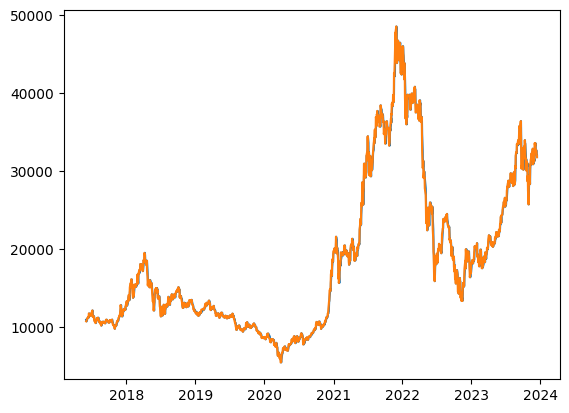

In [15]:
X = SSI[['Close']]
y = SSI[['Target']]

plt.plot(X)
plt.plot(y)
plt.show()

In [16]:
# chia train, test
train_size = int(0.7 * len(SSI))
test_size = len(SSI) - train_size

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

In [17]:
# Define the parameter grid
# Define a dictionary 'params' where keys are hyperparameters of the XGBoost model,
# and values are lists of possible values for each hyperparameter
params = {
    'max_depth': [3, 7],
    'learning_rate': [0.05,0.2],
    'n_estimators': [700, 1000],
    'colsample_bytree': [0.5,1]
}

# Create an XGBRegressor instance
xgbr = XGBRegressor()

# Create a GridSearchCV instance
model = GridSearchCV(
    estimator=xgbr,
    param_grid=params,
    scoring='neg_mean_squared_error',
    verbose=1
)

model.fit(X_train, y_train)

print("Best parameters:", model.best_params_)
print("Lowest RMSE:", (-model.best_score_)**(1/2.0))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 700}
Lowest RMSE: 5767.6648714871335


In [26]:
from xgboost import XGBRegressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=700,colsample_bytree=0.5, learning_rate=0.2, max_depth=7)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [27]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1,1)
print(len(y_pred))
print(len(y_test))

492
492


In [20]:
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
msle = mean_squared_log_error(y_pred, y_test)

print("MAPE:", mape)
print("MAE: ",  mae)
print("RMSE:",rmse)
print ("MLSE:", msle)

MAPE: 3.0592052872287736
MAE:  772.2356433403202
RMSE: Target    1008.765985
dtype: float64
MLSE: 0.0014764407758944811


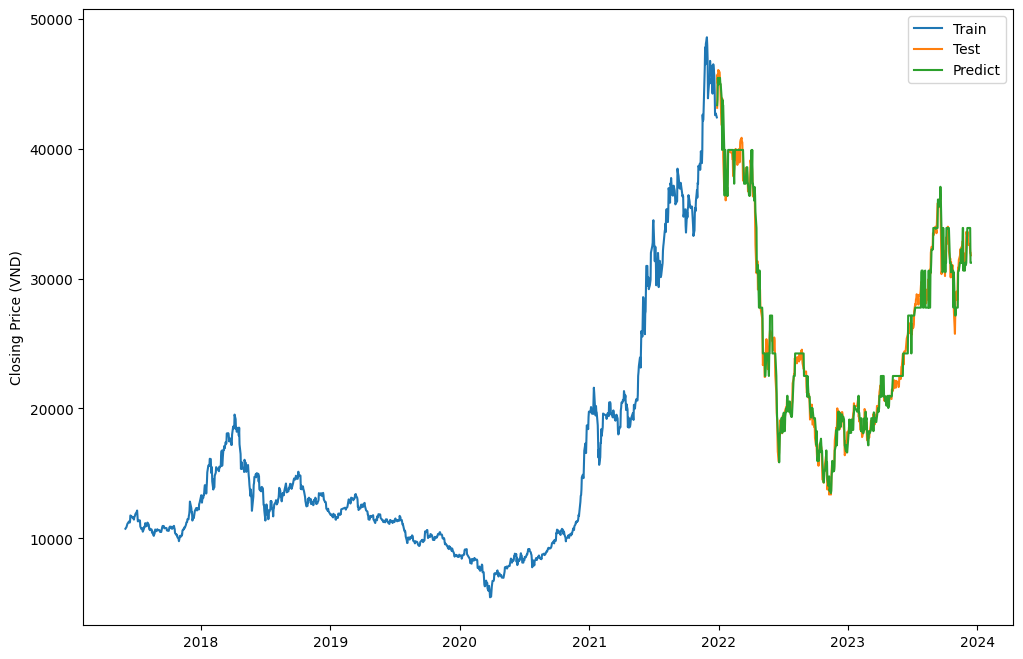

In [21]:
#vẽ mô hình
plt.figure(figsize=(12, 8))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred, label='Predict')
plt.ylabel('Closing Price (VND)')
plt.legend()
plt.show()

In [22]:
# lấy giá trị Close của ngày cuối cùng trong dataset
last_row = SSI.tail(1)
last_data = last_row['Close'].values.reshape(-1,1)
last_data

array([[32000]])

In [23]:
# tạo mảng chứa giá trị predict của 60 ngày tiếp theo
x_next_60_days = []

# predict giá Close 60 ngày tiếp theo dựa vào giá Close của ngày trước đó
for i in range(60):
    x_pred_next = model.predict(last_data)
    x_next_60_days.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)
print("Kết quả dự đoán :", x_next_60_days)


Kết quả dự đoán : [array([31219.79], dtype=float32), array([31057.508], dtype=float32), array([30613.988], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), array([30494.012], dtype=float32), ar

In [24]:
x_next_60_days = np.array(x_next_60_days)
x_next_60_days.reshape(-1,1)

array([[31219.79 ],
       [31057.508],
       [30613.988],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],
       [30494.012],


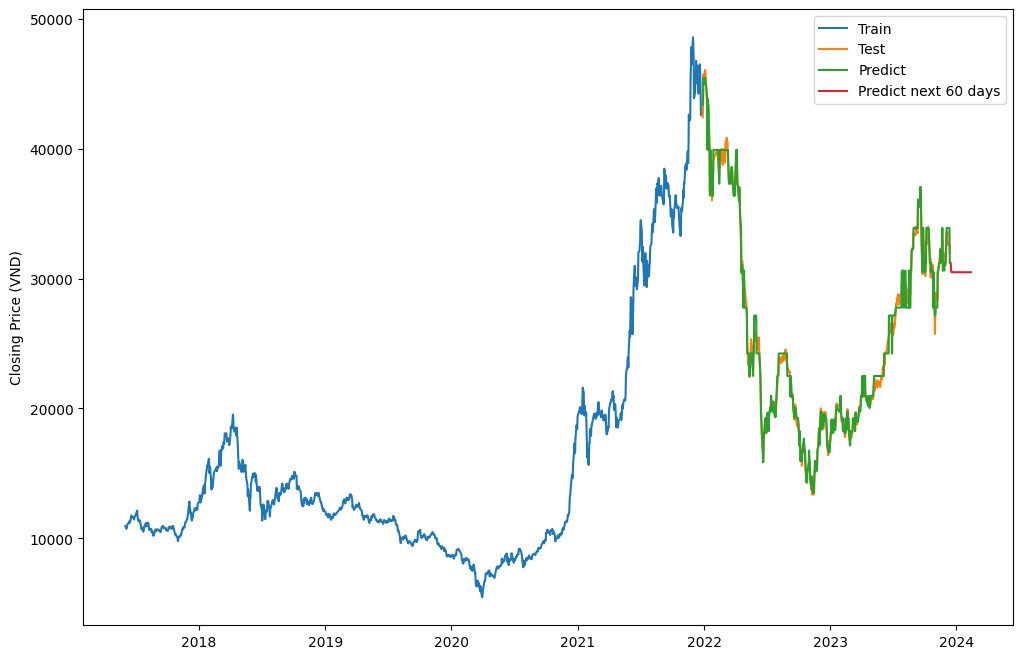

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(X_train, label='Train')
plt.plot(X_test, label='Test')
plt.plot(X_test.index, y_pred, label='Predict')

last_date = X_test.index[-1]
next_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60, freq='D')
plt.plot(next_dates, x_next_60_days, label='Predict next 60 days')

plt.ylabel('Closing Price (VND)')
plt.legend()
plt.show()
